In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [6]:
Features_list=[
  [ 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
  'NBR', 'NDMI', 'NDRE','NDVI', 'TasseledCapGreenness'],
  [ 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
  'NBR', 'NDMI', 'NDRE','NDVI', 'TasseledCapGreenness',
  'VH', 'VV'],
  [ 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
  'NBR', 'NDMI', 'NDRE','NDVI', 'TasseledCapGreenness',
  'elevation', 'slope'],
  [ 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
  'NBR', 'NDMI', 'NDRE','NDVI', 'TasseledCapGreenness',
  'VH', 'VV',
  'elevation', 'slope']
  ]
target='rh95'

In [ ]:
def exclude_outliers(data, target, min_percentile=0.05, max_percentile=99.5):
    min_threshold = np.percentile(data[target].to_numpy().astype(float), min_percentile)
    max_threshold = np.percentile(data[target].to_numpy().astype(float), max_percentile)
    print('min_threshold:', min_threshold)
    print('max_threshold:', max_threshold)
    return data[(data[target] >= min_threshold) & (data[target] <= max_threshold)]

In [ ]:
# Initialize models and hyperparameter grids
models = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 10],
        },
    },
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
        },
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),
        "params": {
            "iterations": [50, 100],
            "depth": [3, 5],
            "learning_rate": [0.01, 0.1],
        },
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 10],
            "learning_rate": [0.01, 0.1],
        },
    },
}
Sensors=['S2','S2+S1','S2+DEM','S2+S1+DEM']


# One Month Window Appoach

In [5]:
data=pd.read_csv('/content/drive/MyDrive/Data/GEDI_S1_S2_DEM.csv')

In [7]:
data[target].max(),data[target].min()

(104.699997, -4.099999904632568)

In [8]:
data = exclude_outliers(data, target)

min_threshold: 1.940000057220459
max_threshold: 35.93909911746586


In [14]:
month_approach_results = pd.DataFrame(columns=["Features", "Model", "Best Params", "RMSE"])

for i,features in enumerate(Features_list):
    features=Features_list[0]

    X = data[features]
    y = data[target]

    # Split data into train and test sets
    X_train, X, y_train, y = train_test_split(X, y, test_size=0.0005, random_state=42)

    for model_name, model_info in models.items():
            print(f"\nTraining model: {model_name}\nFeatures: {Sensors[i]}")

            grid_search = GridSearchCV(
                estimator=model_info["model"],
                param_grid=model_info["params"],
                scoring="neg_mean_squared_error",
                cv=3,
                n_jobs=-1,
            )

            # Perform grid search
            print(f"Performing GridSearchCV for {model_name}...")
            grid_search.fit(X, y)

            best_score = np.sqrt(-grid_search.best_score_)

            # Append results to the DataFrame using pd.concat
            month_approach_results = pd.concat([month_approach_results, pd.DataFrame([{
                "Features":Sensors[i] ,
                "Model": model_name,
                "Best Params": grid_search.best_params_,
                "RMSE": best_score,
            }])], ignore_index=True)




Training model: Random Forest
Features: S2
Performing GridSearchCV for Random Forest...


<ipython-input-14-5bb528aff026>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  month_approach_results = pd.concat([month_approach_results, pd.DataFrame([{



Training model: AdaBoost
Features: S2
Performing GridSearchCV for AdaBoost...

Training model: CatBoost
Features: S2
Performing GridSearchCV for CatBoost...

Training model: XGBoost
Features: S2
Performing GridSearchCV for XGBoost...

Training model: Random Forest
Features: S2+S1
Performing GridSearchCV for Random Forest...

Training model: AdaBoost
Features: S2+S1
Performing GridSearchCV for AdaBoost...

Training model: CatBoost
Features: S2+S1
Performing GridSearchCV for CatBoost...

Training model: XGBoost
Features: S2+S1
Performing GridSearchCV for XGBoost...

Training model: Random Forest
Features: S2+DEM
Performing GridSearchCV for Random Forest...

Training model: AdaBoost
Features: S2+DEM
Performing GridSearchCV for AdaBoost...

Training model: CatBoost
Features: S2+DEM
Performing GridSearchCV for CatBoost...

Training model: XGBoost
Features: S2+DEM
Performing GridSearchCV for XGBoost...

Training model: Random Forest
Features: S2+S1+DEM
Performing GridSearchCV for Random For




# Overall Median Appoach

In [16]:
data=pd.read_csv('/content/drive/MyDrive/Data/GEDI_S1_S2_DEM_Overall_Median.csv')

In [17]:
data = exclude_outliers(data, target)

min_threshold: 1.9800000190734863
max_threshold: 49.32705131997331


In [18]:
overall_median_approach_results = pd.DataFrame(columns=["Features", "Model", "Best Params", "RMSE"])

for i,features in enumerate(Features_list):
    features=Features_list[0]

    X = data[features]
    y = data[target]

    # Split data into train and test sets
    X_train, X, y_train, y = train_test_split(X, y, test_size=0.0005, random_state=42)

    for model_name, model_info in models.items():
            print(f"\nTraining model: {model_name}\nFeatures: {Sensors[i]}")

            grid_search = GridSearchCV(
                estimator=model_info["model"],
                param_grid=model_info["params"],
                scoring="neg_mean_squared_error",
                cv=3,
                n_jobs=-1,
            )

            # Perform grid search
            print(f"Performing GridSearchCV for {model_name}...")
            grid_search.fit(X, y)

            best_score = np.sqrt(-grid_search.best_score_)

            # Append results to the DataFrame using pd.concat
            overall_median_approach_results = pd.concat([overall_median_approach_results, pd.DataFrame([{
                "Features":Sensors[i] ,
                "Model": model_name,
                "Best Params": grid_search.best_params_,
                "RMSE": best_score,
            }])], ignore_index=True)




Training model: Random Forest
Features: S2
Performing GridSearchCV for Random Forest...


<ipython-input-18-5bb528aff026>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  month_approach_results = pd.concat([month_approach_results, pd.DataFrame([{



Training model: AdaBoost
Features: S2
Performing GridSearchCV for AdaBoost...

Training model: CatBoost
Features: S2
Performing GridSearchCV for CatBoost...

Training model: XGBoost
Features: S2
Performing GridSearchCV for XGBoost...

Training model: Random Forest
Features: S2+S1
Performing GridSearchCV for Random Forest...

Training model: AdaBoost
Features: S2+S1
Performing GridSearchCV for AdaBoost...

Training model: CatBoost
Features: S2+S1
Performing GridSearchCV for CatBoost...

Training model: XGBoost
Features: S2+S1
Performing GridSearchCV for XGBoost...

Training model: Random Forest
Features: S2+DEM
Performing GridSearchCV for Random Forest...

Training model: AdaBoost
Features: S2+DEM
Performing GridSearchCV for AdaBoost...

Training model: CatBoost
Features: S2+DEM
Performing GridSearchCV for CatBoost...

Training model: XGBoost
Features: S2+DEM
Performing GridSearchCV for XGBoost...

Training model: Random Forest
Features: S2+S1+DEM
Performing GridSearchCV for Random For

In [ ]:
month_approach_results['Approach']='One Month Window'
overall_median_approach_results['Approach']='Overall Median'

In [ ]:
df_combined = pd.concat([month_approach_results, overall_median_approach_results], ignore_index=True)

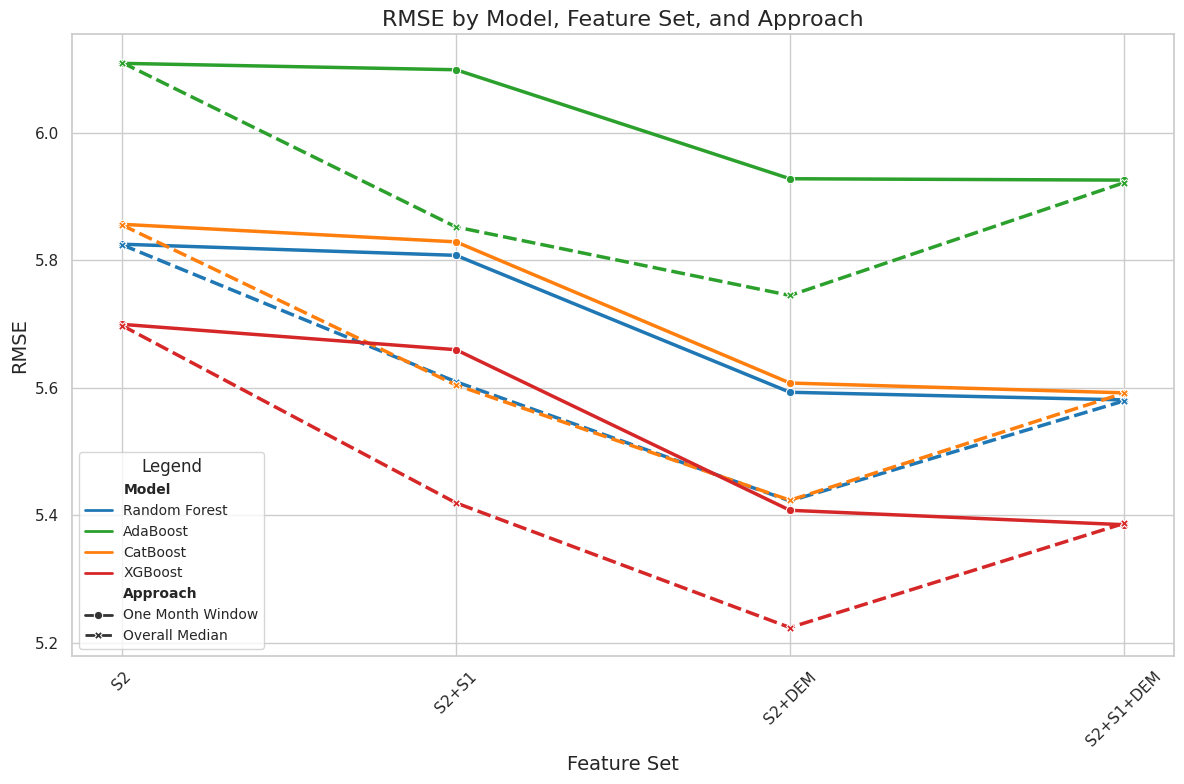

In [ ]:
sns.set_theme(style="whitegrid")

# Define a custom color palette
custom_palette = {
    'Random Forest': '#1f77b4',  # Blue
    'AdaBoost': '#2ca02c',       # Green
    'CatBoost': '#ff7f0e',       # Orange
    'XGBoost': '#d62728',        # Red
}

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=df_combined,
    x="Features",
    y="RMSE",
    hue="Model",              # Different color for each model
    style="Approach",         # Different line styles for each approach
    markers=True,             # Add markers
    palette=custom_palette,   # Custom colors for models
    linewidth=2.5             # Thicker lines for better visibility
)

# Customize the plot
plt.title("RMSE by Model, Feature Set, and Approach", fontsize=16)
plt.xlabel("Feature Set", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

# Customize the legend
legend = plt.legend(title="Legend", fontsize=10, title_fontsize=12, loc='lower left')
for i,text in enumerate(legend.get_texts()):
    if i == 0 or i==5:
      text.set_fontweight('bold')

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
